# Проведение A/B теста

### Описание проекта:

В данном проекте представлены данные отдела маркетинга интернет-магазина для проведения A/B теста. 

Цель проекта - запустить А/В тест и проанализировать результаты.

### План проекта

- Анализ кумулятивных и относительных показателей продаж по группам;
- расчет и анализ 95-ого и 99-ого перцентиля количества заказов на пользователя и стоимости заказов;
- анализ статистической значимости различий в среднем количестве заказов на посетителя, в среднем чеке заказа между группами по «сырым» и "очищенным" данным;
- анализ результатов теста:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Описание данных

Файл orders.csv:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Анализ А/В теста 

In [7]:
orders = pd.read_csv('orders.csv')
display(orders.head())
orders.info()
visitors = pd.read_csv('visitors.csv')
visitors.info()
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
print(visitors['group'].unique())
print(orders['group'].unique())
print(visitors['date'].min())
print(visitors['date'].max())
print(orders['date'].min())
print(orders['date'].max())


['A' 'B']
['B' 'A']
2019-08-01 00:00:00
2019-08-31 00:00:00
2019-08-01 00:00:00
2019-08-31 00:00:00


In [10]:
groups_count_df = orders.groupby('visitorId').agg({'group':'nunique'}).reset_index()
visitors_with_multiple_groups = groups_count_df[groups_count_df['group'] > 1]
display(visitors_with_multiple_groups.head())
orders = orders.query('visitorId not in @visitors_with_multiple_groups["visitorId"]')
orders.head()

,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [17]:
print(orders.groupby('group').agg({'visitorId':'count'}))

       visitorId
group           
A            468
B            548


<div class="alert alert-info">
В данных представленны две группы для анализа - А и В. Данные представлены за период с 1 августа 2019 года по 31 августа 2019 года в таблицах orders и visitors. Были найдены и исключены пользователи, попавшие в обе группы. По итогу в группе А - 468 пользователей, в группе В - 548 пользователей.

### График кумулятивной выручки по группам

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


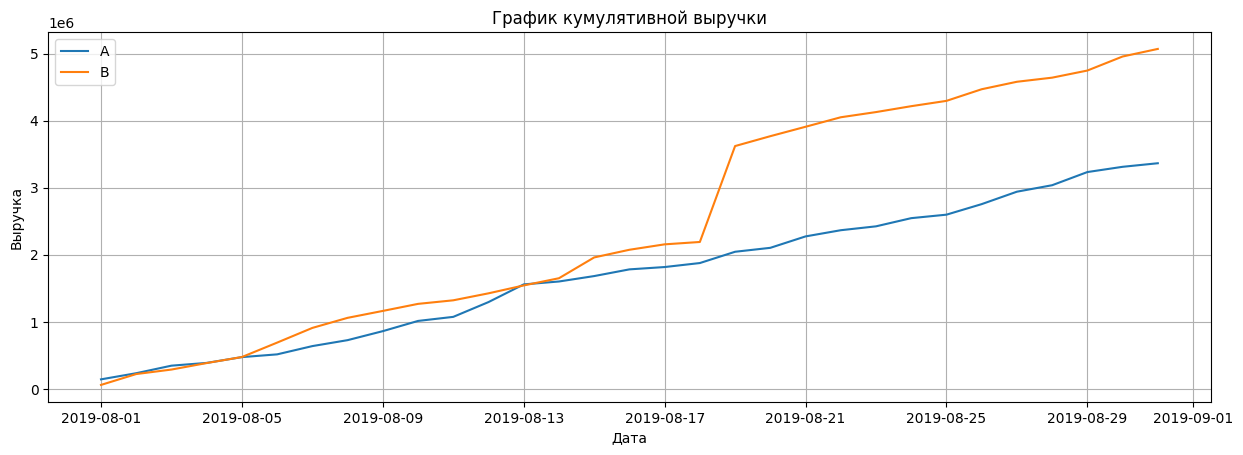

In [24]:
datesGroups = orders[['date','group']].drop_duplicates() 
ordersAggregated = (datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group']))

visitorsAggregated = (datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group']))

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
fig, ax = plt.subplots()
ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
fig.set_figwidth(15)
plt.grid()
plt.legend()
plt.title('График кумулятивной выручки')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

<div class="alert alert-info"> Выручка по обеим группам растет в течение периода. В 20-х числах августа выручка группы В резко возросла. Разница между группами  составила около 1,5 млн рублей. До конца периода сохраняется эта разница в выручке между группами. Этот скачек может свидетельствовать об аномальных значениях: всплеск числа заказов или появление дорогих заказов в выборке, но также и о том, что реализация гипотезы по повышению выручки сработала.

### График кумулятивного среднего чека по группам

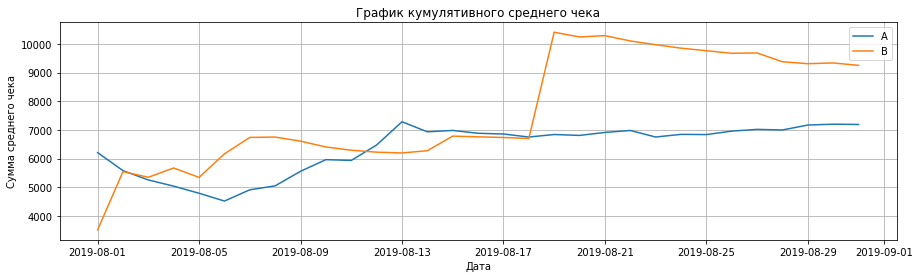

In [11]:
fig, ax = plt.subplots()
ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / 
         cumulativeRevenueA['orders'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / 
         cumulativeRevenueB['orders'], label='B')
fig.set_figwidth(15)
plt.grid()
plt.legend() 
plt.title('График кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')

plt.show()

<div class="alert alert-info"> График также говорит о том, что в середине периода в группе В наблюдается резкий рост продаж, растет и средний чек. За несколько дней средний чек, находившийся в пределах 7000, вырос и стал более 10000, далее до конца периода размер среднего чека группы В постепенно снижался, на конец период средний чек упал почти на 1000 единиц. В группе А на всем периоде средний чек сохраняет значения в интервале от 5000 до 70000. 

 ### График относительного изменения кумулятивного среднего чека группы B к группе A.

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


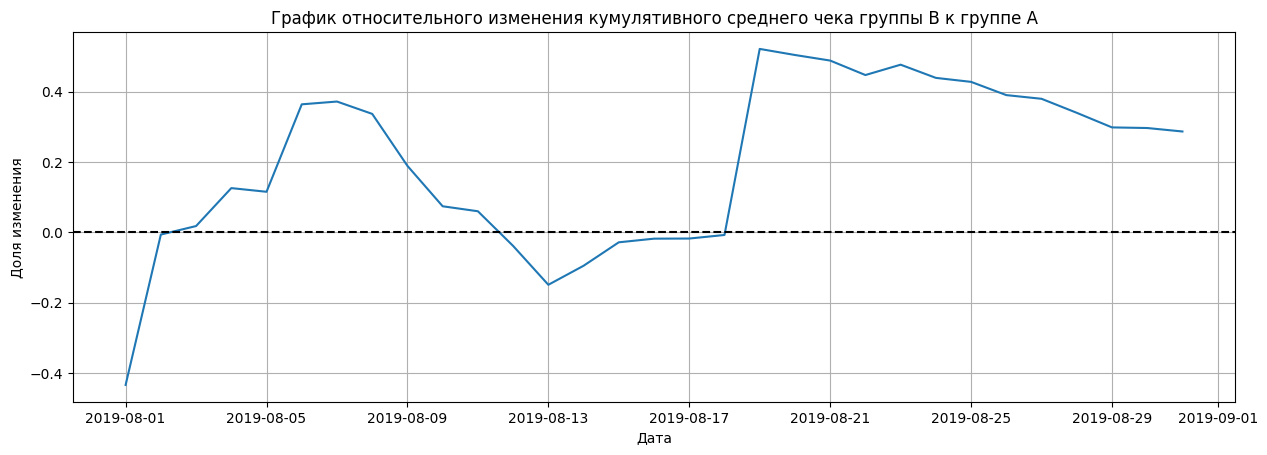

In [8]:
mergedCumulativeRevenue = cumulativeRevenueA. \
    merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
display(mergedCumulativeRevenue.head())
fig, ax = plt.subplots()
ax.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
fig.set_figwidth(15)
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Доля изменения')
plt.show()

<div class="alert alert-info"> На протяжении всего периода наблюдаются скачи и падения, возможно где-то все таки есть аномалии. Правая половина графика схожа с графиком среднего чека группы В. Дело в том, что данные группы А более стабильны и находились примерно на одном уровне, а в группе В данные росли и падали. 

### График кумулятивной конверсии по группам

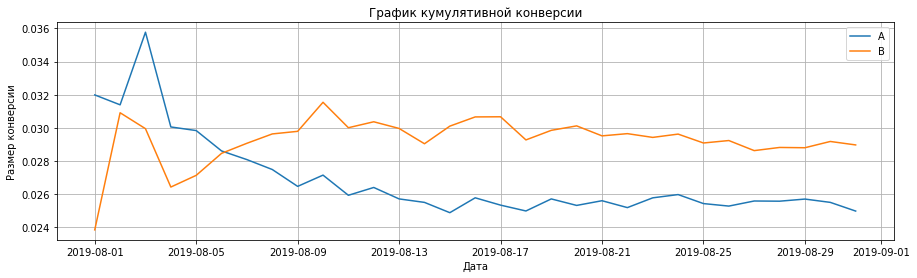

In [13]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
fig, ax = plt.subplots()
ax.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
ax.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
fig.set_figwidth(15)
plt.legend()
plt.grid()
plt.title('График кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Размер конверсии')
plt.show()

<div class="alert alert-info"> В графиках группы А и В наблюдается симметрия. В начале скачки и падения были в обеих группах. Далее на протяжении всего периода конверсия группы В колебалась в периоде от 0.029 до 0.032, конверсия группа А демонстрирует спад и колебания в интервале от 0.025 до 0.027.

### График относительного изменения кумулятивной конверсии группы B к группе A

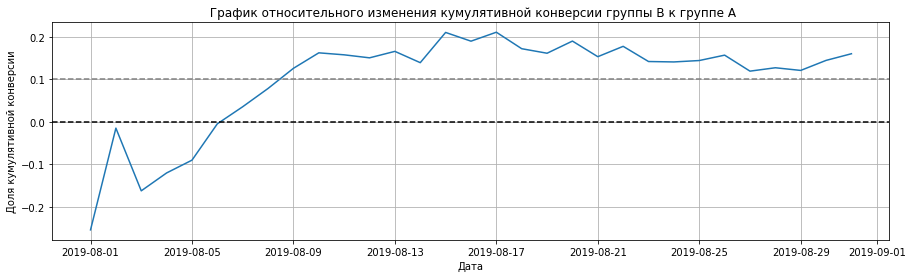

In [14]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']] 
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', 
           how='left', suffixes=['A', 'B']))
fig, ax = plt.subplots()
ax.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)
fig.set_figwidth(15)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='gray', linestyle='--')
plt.grid()
plt.title(' График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Доля кумулятивной конверсии')
plt.show()

<div class="alert alert-info"> В первые 6 дней кумулятивная конверсия в группе В была меньше чем в группе А, однако с 6 числа и до конца периода конверсия группы В превышает конверсию в группе А. График группы В стабилизировался около 0.15.

### Точечный график количества заказов по пользователям 

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


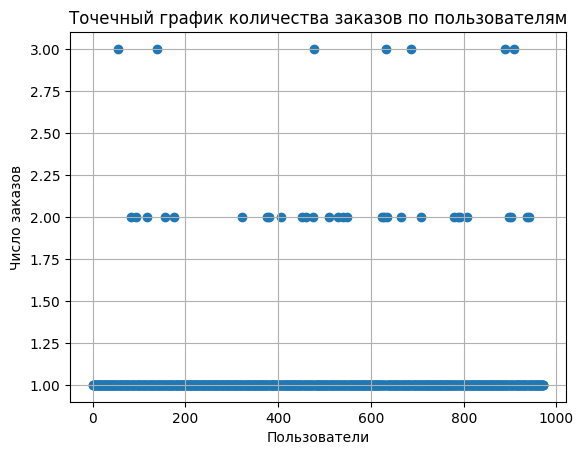

In [25]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Число заказов')
plt.grid()
plt.show()

<div class="alert alert-info"> Согласно графику есть единичные пользователи, которые совершили 3 заказа, есть много пользователей с 1 заказом, далее с увеличением числа заказов пользователей все меньше. Пока что сложно понять с какого размера заказов начинаются аномалии: либо с 2 либо с 3.

### Расчет перцентилей количества заказов на пользователя

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))
percentile_95_orders = np.percentile(ordersByUsers['orders'], 95)
print(percentile_95_orders)

[1. 2.]
1.0


<div class="alert alert-info"> 5% пользователей оформили более 1 заказа, 1% пользователей оформил более 2 заказов. Границей  для определения аномалий можно считать более 1 заказа.

### Точечный график стоимостей заказов

425     1294500
1196     202740
1136      92550
744       86620
743       67990
Name: revenue, dtype: int64


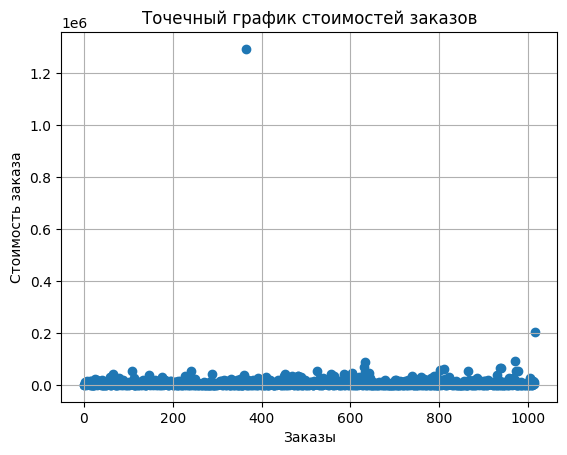

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
print(orders['revenue'].sort_values(ascending=False).head())
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.show()

<div class="alert alert-info"> Согласно графику стоимость заказов обычно находится в пределах 100 тысяч. Имеется два выбивающихся значения - 1 294 500 рублей и 202740 рублей.

###  Расчет перцентилей стоимости заказов

In [28]:
print(np.percentile(orders['revenue'], [95, 99]))
percentile_95_revenue = np.percentile(orders['revenue'], 95)
print(percentile_95_revenue)

[26785. 53904.]
26785.0


<div class="alert alert-info"> Не более 5% заказов дороже 26785 рублей и не более 1% заказов дороже 53904 рублей. Границей для определения аномалий можно считать заказы стоимостью более 26785 рублей.

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным 

При расчете статистической значимости в первую очередь необходимо сформулировать гипотезы.

Нулевая гипотеза: между группами нет различий в конверсии.
Альтернативная гипотеза: между группами имеются различия в конверсии.

In [29]:
visitors_a = visitors.loc[visitors['group'] == 'A'].groupby('date')['visitors'].sum()
visitors_b = visitors.loc[visitors['group'] == 'B'].groupby('date')['visitors'].sum()

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a.sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b.sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


<div class="alert alert-info"> p-value=0.011, что меньше 0.05, следовательно гипотеза о том что конверсии в группах равны маловероятна и от нее необходимо отказаться. В среднем конверсия в группах различается на 16% что также подтверждает вывод о том, что нулевая гипотеза не подтвердилась.

### Расчет статистической значимости различий  в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: в среднеем чеке по группам нет различий.
Альтернативная гипотеза: в среднем чеке по группам имеются различия.

In [20]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() / 
                       orders[orders['group']=='A']['revenue'].mean() - 1))

0.829
0.287


<div class="alert alert-info"> p-value равно 0.829, что значительно больше 0.05, следовательно нулевая гипотеза не может быть отвергнута. Однако относительная разница между средним чеком группы В и группы А равна 28.7%

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным 

Нулевая гипотеза: между группами нет различий в конверсии.
Альтернативная гипотеза: между группами имеются различия в конверсии.

In [21]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > percentile_95_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > percentile_95_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > percentile_95_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
86


In [22]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a.sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b.sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [23]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.016
0.174


<div class="alert alert-info"> На очищенных данных значение p-value составило 0.016, что больше 0.05. Следовательно по очищенным данным результат крайне мал для подтверждения нулевой гипотезы. Об этом также свидетельствует расчет средней разницы (17%) между конверсиями групп. Нулевая гипотеза также должна быть отвергнута.


### Расчет статистической значимости различий  в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: в среднеем чеке по группам нет различий.
Альтернативная гипотеза: в среднем чеке по группам имеются различия.

In [24]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.727
-0.034


<div class="alert alert-info"> На очищенных данных по средему чеку значение p-value уменьшилось, но по-прежнему боле 0.05, следовательно нулевая гипотеза не может быть отвергнута. На сырых данных в среднем различие между средним чеком составляло 29%, на очищенных данных в среднем разница составляет 3.4% в пользу группы А, можно сказать, что размер чека в среднем схож по обеим группам.

## Вывод

<div class="alert alert-info"> В проекте были представленны данные за август 2019 года по заказам группы А и В. На начальном этапе были исключены из анализа пользователи, которые попали в обе группы.
Исходя из проведенного анализа можно сделать следующие выводы:

- График кумулятивной выручки демонстрирует рост по обеим группам, однако в первых числах месяца рост значений в группе В превысил рост в группе А;
- График кумулятивного среднего чека также отражает скачек данных по группе В;
- График кумулятивной конверсии выглядит симметрично, примерно с 6 числа конверсия группы В стабильно выше конверсии по группе А;
- В среднем пользователь осуществил за анализируемый период от 1 до 3 заказов. При расчете персентилей было принято считать пользователей, которые оформили более 1 заказа, аномалиями;
- Были проведен анализ и по сумме заказа: 95% заказов -  до 30 тысяч рублей, однако были найдены аномально большие заказы. С помощью расчета персентилей было принято считать заказы со стоимостью более 26785 аномальными.
- Был проведен расчет статистической значимости по сырым данным и "очищенным" (без аномалий): При этих расчетах гипотезу, о том что конверсии по группам равны, были вынуждены отвергнуть. А вот гипотезу о том, что средний чек в группах не различается, нет возможности отвергнуть. По очищенным данным в среднем разница между средним чеком составила 3.4% - что можно считать незначительной разницей.

Динамика графиков и расчет статистической значимости конверсии по группам говорит нам о том, что группа В показывает динамику лучше и конверсия стабильно больше, чем в группе А. Следовательно стоит остановить тест, зафиксировать победу группы В.